### Analysis of the scraped data

#### Fossil fuel and renewables data cleaning, aggregating and plotting (all in thousands of megawatthours)

 - Fossil and renewable energy data both show net generation per month, by energy source
 - See Spider files for exactly what is included under each heading

In [18]:
import numpy as np
from scipy import stats
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from pylab import rcParams
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import colorlover as cl

###### Read in data from the scraped csv's

In [2]:
old_renewable_data_path = Path("renewable_energy_old/RenewableEnergyOld.csv")
renewable_generation = pd.read_csv(old_renewable_data_path, index_col = 5)

old_fossil_data_path = Path("fossil_energy_old/FossilEnergyOld.csv")
fossil_fuel_generation = pd.read_csv(old_fossil_data_path, index_col = 4)

In [3]:
new_renewable_data_path = Path("renewable_energy_new/RenewableEnergyNew.csv")
renewable_generation = renewable_generation.append(pd.read_csv(new_renewable_data_path, index_col = 5))

new_fossil_data_path = Path("fossil_energy_new/FossilEnergyNew.csv")
fossil_fuel_generation = fossil_fuel_generation.append(pd.read_csv(new_fossil_data_path, index_col = 4))

In [4]:
fossil_fuel_generation.drop_duplicates(inplace = True)

In [5]:
print(fossil_fuel_generation.shape)
print(fossil_fuel_generation.head(1))
print(fossil_fuel_generation.tail(1))
print(renewable_generation.shape)
print(renewable_generation.head(1))
print(renewable_generation.tail(1))

(49, 6)
                coal  natural_gas  nuclear  other_gas  petro_coke  \
period                                                              
January 2015  132451       101687    74270       1246        1046   

              petro_liquids  
period                       
January 2015           1927  
                coal  natural_gas  nuclear  other_gas  petro_coke  \
period                                                              
January 2019  101019       118935    73701        994         820   

              petro_liquids  
period                       
January 2019           1316  
(49, 10)
              bmsw  geothermal  hydro  landfill_gas  other_waste  \
period                                                             
January 2015   582        1362  24138           885          258   

              solar_thermal  solarpv_small  solarpv_utility   wind  wood  
period                                                                    
January 2015             63     

In [6]:
print(fossil_fuel_generation.dtypes)
print(renewable_generation.dtypes)

coal             int64
natural_gas      int64
nuclear          int64
other_gas        int64
petro_coke       int64
petro_liquids    int64
dtype: object
bmsw               int64
geothermal         int64
hydro              int64
landfill_gas       int64
other_waste        int64
solar_thermal      int64
solarpv_small      int64
solarpv_utility    int64
wind               int64
wood               int64
dtype: object


In [7]:
# Join the tables to make a plot featuring all of the main energy sources
energy_gen = pd.merge(fossil_fuel_generation,renewable_generation, how = 'inner', left_index = True, right_index = True)

In [8]:
# Following Plot.ly example for filled area plot, altering xticks and adding chart title and axis labels
x = energy_gen.index.tolist()
linewidth = 1.5
brbg = cl.scales['10']['div']['BrBG']

coal = dict(x=x, y=energy_gen['coal'].tolist(), legendgroup = 'Fossil', hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[1]), stackgroup='one', name='Coal')

petroleum = dict(x=x, y=(energy_gen['petro_coke']+energy_gen['petro_liquids']).tolist(), \
                 legendgroup = 'Fossil', hoverinfo='x+y', mode='lines', line=dict(width=linewidth, color = brbg[3]), name='Petroleum', stackgroup='one')

gas = dict(x=x, y=(energy_gen['natural_gas']+energy_gen['other_gas']).tolist(), \
                 legendgroup = 'Fossil', hoverinfo='x+y', mode='lines', line=dict(width=linewidth, color = brbg[0]), name = 'Gas', stackgroup='one')

nuclear = dict(x=x, y=energy_gen['nuclear'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[2]), name = 'Nuclear', stackgroup='one')

wind = dict(x=x, y=energy_gen['wind'].tolist(), legendgroup = 'Renewable', hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-4]), stackgroup='one', name='Wind')

solar = dict(x=x, y=(energy_gen['solarpv_utility']+energy_gen['solarpv_small']+energy_gen['solar_thermal']).tolist(), \
             legendgroup = 'Renewable', hoverinfo='x+y', mode='lines',line=dict(width=linewidth, color = brbg[-3]), stackgroup='one', name='Solar')

biomass = dict(x=x, y=(energy_gen['bmsw']+energy_gen['landfill_gas']+energy_gen['other_waste']+energy_gen['wood']).tolist(), \
             legendgroup = 'Renewable', hoverinfo='x+y', mode='lines',line=dict(width=linewidth, color = brbg[-2]), stackgroup='one', name='Biomass')

geothermal = dict(x=x, y=energy_gen['geothermal'].tolist(), legendgroup = 'Renewable', hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-1]), stackgroup='one', name='Geothermal')

hydro = dict(x=x, y=energy_gen['hydro'].tolist(), legendgroup = 'Renewable', hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-5]), stackgroup='one', name='Hydro')

data=[gas, coal, nuclear, petroleum, hydro, wind, solar, biomass, geothermal]

labels = ['January 2015', 'January 2016','January 2017','January 2018','January 2019']
tickvals = ['January 2015', 'January 2016','January 2017','January 2018','January 2019']

layout = dict(title = 'Monthly energy generation',
              xaxis=go.layout.XAxis(ticktext=labels,tickvals=tickvals, title='Month', tickangle=20),\
              yaxis = dict(title = '000\'s of megawatt hours', exponentformat='e'),
              shapes = [{ 'type':'line', 'x0':'20 January 2017', 'y0':0, 'x1':'20 January 2017', 'y1':400000, \
                            'line':dict(color = '#ff0000', width = 1, dash = 'dashdot')}])

fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig)


 - Looks as if there is an annual pattern in the above data - lets split it before and after Trump was inaugurated, and see if there has been a change in the monthly averages
 - Do this separately for renewables and fossil fuels to make dealing with the gropued tables easier

In [9]:
# For the total energy frame, split it either side of Trump's inauguration,
# get the months as a column on their own, make them categorical so that they 
# retain order

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', \
          'September', 'October', 'November', 'December']

energy_gen['month'] = energy_gen.index.map(lambda x: re.sub('[\d\s]','',x))
energy_gen['month']= pd.Categorical(energy_gen['month'], categories = months, ordered = True)

pre_trump = energy_gen.loc['January 2015':'January 2017']
post_trump = energy_gen.loc['February 2017':]

In [10]:
# Group the two resulting frames to average over the time period for each month, then add
# columns showing the total renewable/fossil energy/nuclear (i.e. summed over the sources, have to delve
# into the MultiIndex object of the grouped data frame)

group_pre_t = pre_trump.groupby('month').agg(['mean'])
group_post_t = post_trump.groupby('month').agg(['mean'])

# Exclude nuclear from the column names, as it is not really renewable or fossil
# Make a vector to index with that selects just the renewable/fossil columns to sum

r_col_logical = [True if i in set(renewable_generation.columns) else False for i in group_pre_t.columns.levels[0]]
group_pre_t['total_renewable'] = group_pre_t.loc[:,r_col_logical].sum(axis = 1)
group_post_t['total_renewable'] = group_post_t.loc[:,r_col_logical].sum(axis = 1)

no_nuclear = group_pre_t.columns.levels[0][group_pre_t.columns.levels[0] != 'nuclear']
f_col_logical = [True if i in set(fossil_fuel_generation.columns) else False for i in no_nuclear]
group_pre_t['total_ff'] = group_pre_t.loc[:,no_nuclear].loc[:,f_col_logical].sum(axis = 1)
group_post_t['total_ff'] = group_post_t.loc[:,no_nuclear].loc[:,f_col_logical].sum(axis = 1)

Now plot the nuclear, total renewable and total fossil fuel monthly average for the two portions of time and see if we can see a big difference

In [11]:

dark2 = cl.scales['6']['qual']['Dark2']
pre_t_ff = go.Scatter(x=months, y = list(group_pre_t['total_ff']), name = 'Pre Trump fossil fuels', \
                      line = dict(color = dark2[0],width = 4))

post_t_ff = go.Scatter(x=months, y = list(group_post_t['total_ff']), name = 'Post Trump fossil fuels', \
                       line = dict(color = dark2[1],width = 4))

data2 = [pre_t_ff, post_t_ff]

layout2 = dict(title = 'Pre and post inauguration average fossil fuel generation', xaxis = dict(title = 'Month'),\
              yaxis = dict(title = '000\'s of megawatt hours'))

fig2 = dict(data=data2, layout=layout2)
plotly.offline.iplot(fig2)

In [24]:
dark2 = cl.scales['6']['qual']['Dark2']

pre_t_r = go.Scatter(x=months, y = list(group_pre_t['total_renewable']), name = 'Pre Trump renewables', \
                       line = dict(color = dark2[2],width = 4))

post_t_r = go.Scatter(x=months, y = list(group_post_t['total_renewable']), name = 'Post Trump renewables', \
                       line = dict(color = dark2[3],width = 4))

pre_t_n = go.Scatter(x=months, y = list(group_pre_t['nuclear']['mean']), name = 'Pre Trump nuclear', \
                       line = dict(color = dark2[4],width = 4))

post_t_n = go.Scatter(x=months, y = list(group_post_t['nuclear']['mean']), name = 'Post Trump nuclear', \
                       line = dict(color = dark2[5],width = 4))
data3 = [pre_t_r, post_t_r, pre_t_n, post_t_n]

layout3 = dict(title = 'Pre and post inauguration average renewable and nuclear generation', xaxis = dict(title = 'Month'),\
              yaxis = dict(title = '000\'s of megawatt hours'))

fig3= dict(data=data3, layout=layout3)
plotly.offline.iplot(fig3)

 - Doesn't seem to be much difference! In fact, looks like post-Trump there has been an average decrease in fossil fuel generation, and an average increase in renewable generation.
 - Use statistical tests to see if this difference is significant

In [13]:
renewable_generation['total'] = renewable_generation.sum(axis = 1)
ren_gen_pre_t = renewable_generation.loc['January 2015':'January 2017']
ren_gen_post_t = renewable_generation.loc['February 2017':]

In [14]:
fossil_fuel_generation['total'] = fossil_fuel_generation.loc[:,['coal', 'natural_gas', 'other_gas', 'petro_coke', 'petro_liquids']].sum(axis = 1)
fos_gen_pre_t = fossil_fuel_generation.loc['January 2015':'January 2017']
fos_gen_post_t = fossil_fuel_generation.loc['February 2017':]

In [15]:
# Two sample t-test comparing means of fossil fuel generation time series before and after T-Day
stats.ttest_ind(np.array(fos_gen_pre_t['total']), np.array(fos_gen_post_t['total']), equal_var = False)

Ttest_indResult(statistic=0.7326675099265674, pvalue=0.46739999398720045)

 - p-value well above threshold, therefore **cannot reject the null hypothesis that the mean fossil fuel generation before and after Trump's inauguration is the same** 

In [16]:
# Two sample t-test for renewable generation
stats.ttest_ind(np.array(ren_gen_pre_t['total']), np.array(ren_gen_post_t['total']), equal_var = False)

Ttest_indResult(statistic=-6.594688768711309, pvalue=4.50831416284386e-08)

 - p-value well below threshold, therefore **reject the null hypothesis that the mean renewable generation is the same either side of the inauguration**
 - Was the renewable generation already on an upward trend before the inauguration? This requires further time series analysis

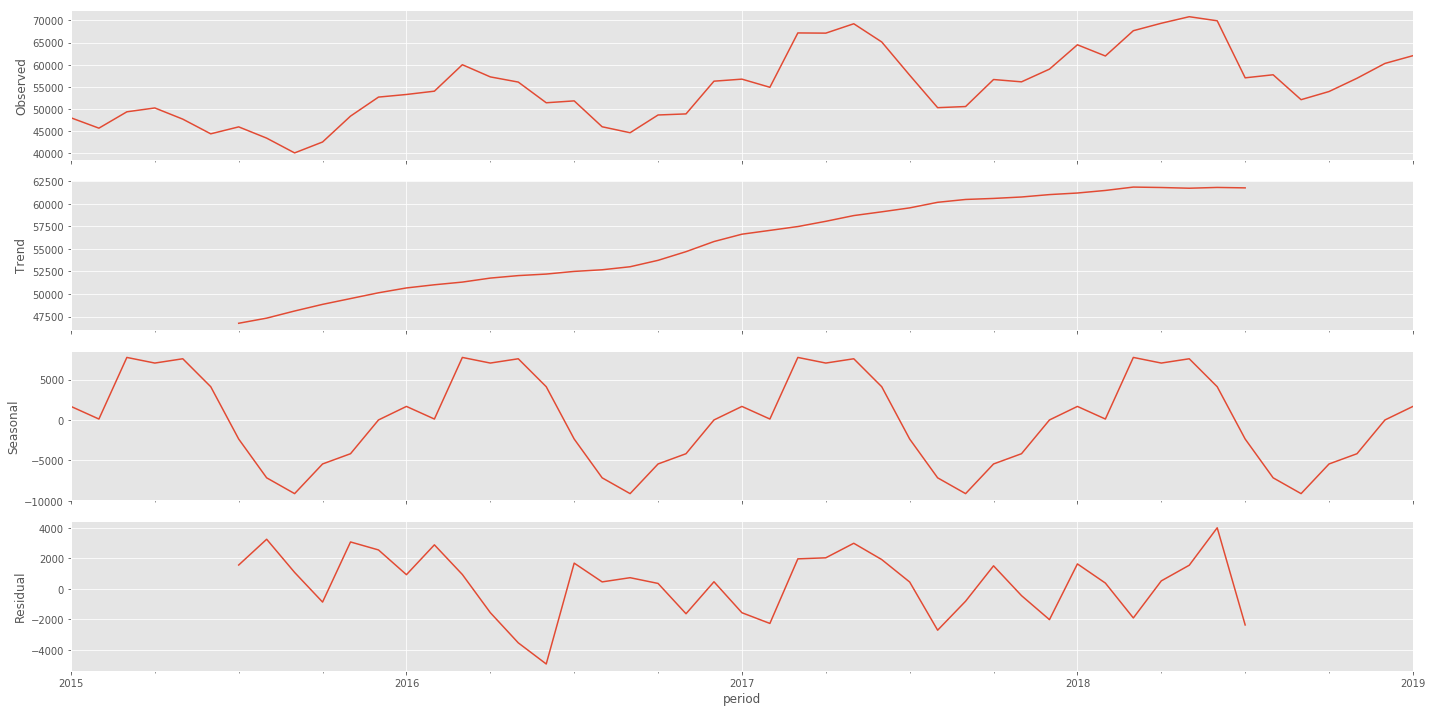

In [26]:
# Make a copy of the renewable generation data frame, changing the index to a datetime to make a timeseries
ren_gen_datetime_index = renewable_generation.copy()
ren_gen_datetime_index.index = pd.to_datetime(ren_gen_datetime_index.index)

# Decompose the time series data into three components
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(ren_gen_datetime_index['total'], model='additive')
fig = decomposition.plot()
plt.show()